# Kd Tree Binning
<hr style="border-top-width: 4px; border-top-color: #34609b;">
kdTreeBinning tutorial: bin the data in cells of equal content using a kd-tree

Using TKDTree wrapper class as a data binning structure
 Plot the 2D data using the TH2Poly class




**Author:** Bartolomeu Rabacal  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-mirror/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer (Beta)</a> from the macro found in the ROOT repository  on Thursday, January 19, 2017 at 04:32 PM.</small></i>

In [1]:
%%cpp -d
#include <math.h>

#include "TKDTreeBinning.h"
#include "TH2D.h"
#include "TH2Poly.h"
#include "TStyle.h"
#include "TGraph2D.h"
#include "TRandom3.h"
#include "TCanvas.h"
#include <iostream>

-----------------------------------------------------------------------------------------------
  Create random sample with regular binning plotting

In [2]:
const UInt_t DATASZ = 10000;
const UInt_t DATADIM = 2;
const UInt_t NBINS = 50;

Double_t smp[DATASZ * DATADIM];

double mu[2] = {0,2};
double sig[2] = {2,3};
TRandom3 r;
r.SetSeed(1);
for (UInt_t i = 0; i < DATADIM; ++i)
   for (UInt_t j = 0; j < DATASZ; ++j)
      smp[DATASZ * i + j] = r.Gaus(mu[i], sig[i]);

UInt_t h1bins = (UInt_t) sqrt(NBINS);

TH2D* h1 = new TH2D("h1BinTest", "Regular binning", h1bins, -5., 5., h1bins, -5., 5.);
for (UInt_t j = 0; j < DATASZ; ++j)
   h1->Fill(smp[j], smp[DATASZ + j]);

---------------------------------------------------------------------------------------------
 Create KDTreeBinning object with TH2Poly plotting

In [3]:
TKDTreeBinning* kdBins = new TKDTreeBinning(DATASZ, DATADIM, smp, NBINS);

UInt_t nbins = kdBins->GetNBins();
UInt_t dim   = kdBins->GetDim();

const Double_t* binsMinEdges = kdBins->GetBinsMinEdges();
const Double_t* binsMaxEdges = kdBins->GetBinsMaxEdges();

TH2Poly* h2pol = new TH2Poly("h2PolyBinTest", "KDTree binning", kdBins->GetDataMin(0), kdBins->GetDataMax(0), kdBins->GetDataMin(1), kdBins->GetDataMax(1));

for (UInt_t i = 0; i < nbins; ++i) {
   UInt_t edgeDim = i * dim;
   h2pol->AddBin(binsMinEdges[edgeDim], binsMinEdges[edgeDim + 1], binsMaxEdges[edgeDim], binsMaxEdges[edgeDim + 1]);
}

for (UInt_t i = 1; i <= kdBins->GetNBins(); ++i)
   h2pol->SetBinContent(i, kdBins->GetBinDensity(i - 1));

std::cout << "Bin with minimum density: " << kdBins->GetBinMinDensity() << std::endl;
std::cout << "Bin with maximum density: " << kdBins->GetBinMaxDensity() << std::endl;

TCanvas* c1 = new TCanvas("glc1", "TH2Poly from a kdTree",0,0,600,800);
c1->Divide(1,3);
c1->cd(1);
h1->Draw("lego");

c1->cd(2);
h2pol->Draw("COLZ L");
c1->Update();

Bin with minimum density: 13
Bin with maximum density: 29


-------------------------------------------------
 Draw an equivalent plot showing the data points 

In [4]:
std::vector<Double_t> z = std::vector<Double_t>(DATASZ, 0.);
for (UInt_t i = 0; i < DATASZ; ++i)
   z[i] = (Double_t) h2pol->GetBinContent(h2pol->FindBin(smp[i], smp[DATASZ + i]));

TGraph2D *g = new TGraph2D(DATASZ, smp, &smp[DATASZ], &z[0]);
g->SetMarkerStyle(20);

c1->cd(3);
g->Draw("pcol");
c1->Update();

---------------------------------------------------------
 make a new TH2Poly where bins are ordered by the density

In [5]:
TH2Poly* h2polrebin = new TH2Poly("h2PolyBinTest", "KDTree binning", kdBins->GetDataMin(0), kdBins->GetDataMax(0), kdBins->GetDataMin(1), kdBins->GetDataMax(1));
h2polrebin->SetFloat();

---------------------------------
 Sort the bins by their density  

In [6]:
kdBins->SortBinsByDensity();

for (UInt_t i = 0; i < kdBins->GetNBins(); ++i) {
   const Double_t* binMinEdges = kdBins->GetBinMinEdges(i);
   const Double_t* binMaxEdges = kdBins->GetBinMaxEdges(i);
   h2polrebin->AddBin(binMinEdges[0], binMinEdges[1], binMaxEdges[0], binMaxEdges[1]);
}

for (UInt_t i = 1; i <= kdBins->GetNBins(); ++i){
   h2polrebin->SetBinContent(i, kdBins->GetBinDensity(i - 1));}

std::cout << "Bin with minimum density: " << kdBins->GetBinMinDensity() << std::endl;
std::cout << "Bin with maximum density: " << kdBins->GetBinMaxDensity() << std::endl;

Bin with minimum density: 0
Bin with maximum density: 49


Now make a vector with bin number vs position

In [7]:
for (UInt_t i = 0; i < DATASZ; ++i)
  z[i] = (Double_t) h2polrebin->FindBin(smp[i], smp[DATASZ + i]);

TGraph2D *g2 = new TGraph2D(DATASZ, smp, &smp[DATASZ], &z[0]);
g2->SetMarkerStyle(20);

Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).


Plot new th2poly (ordered one) and tgraph2d
 The new TH2Poly has to be same as old one and the TGraph2D should be similar to
 the previous one. It is now made using as z value the bin number

In [8]:
TCanvas* c4 = new TCanvas("glc4", "TH2Poly from a kdTree (Ordered)",50,50,800,800);

c4->Divide(2,2);
c4->cd(1);
h2polrebin->Draw("COLZ L");  // draw as scatter plot

c4->cd(2);
g2->Draw("pcol");

c4->Update();

Make also the 1d binned histograms

In [9]:
TKDTreeBinning* kdX = new TKDTreeBinning(DATASZ, 1, &smp[0], 20);
TKDTreeBinning* kdY = new TKDTreeBinning(DATASZ, 1, &smp[DATASZ], 40);


  kdX->SortOneDimBinEdges();
  kdY->SortOneDimBinEdges();

  TH1* hX=new TH1F("hX", "X projection", kdX->GetNBins(), kdX->GetOneDimBinEdges());
  for(int i=0; i<kdX->GetNBins(); ++i){
 hX->SetBinContent(i+1, kdX->GetBinDensity(i));
  }

  TH1* hY=new TH1F("hY", "Y Projection", kdY->GetNBins(), kdY->GetOneDimBinEdges());
  for(int i=0; i<kdY->GetNBins(); ++i){
 hY->SetBinContent(i+1, kdY->GetBinDensity(i));
  }

  c4->cd(3);
  hX->Draw();
  c4->cd(4);
  hY->Draw();

Draw all canvases 

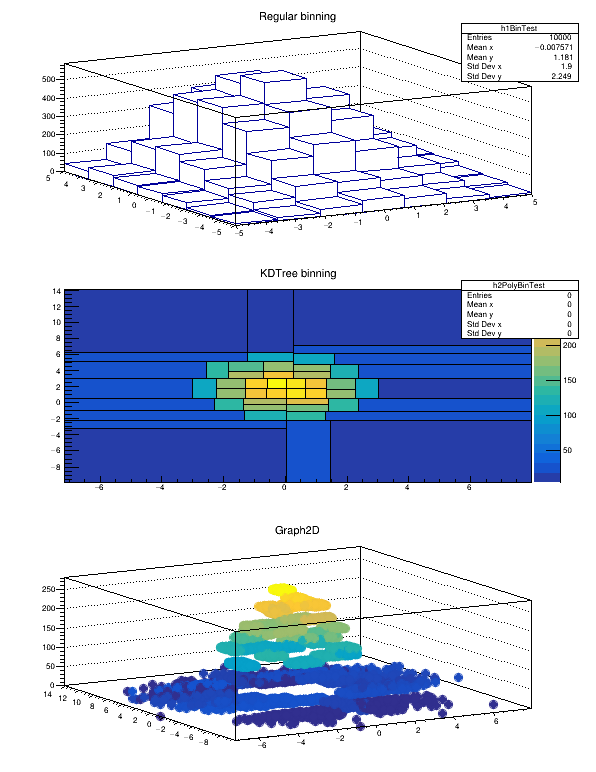

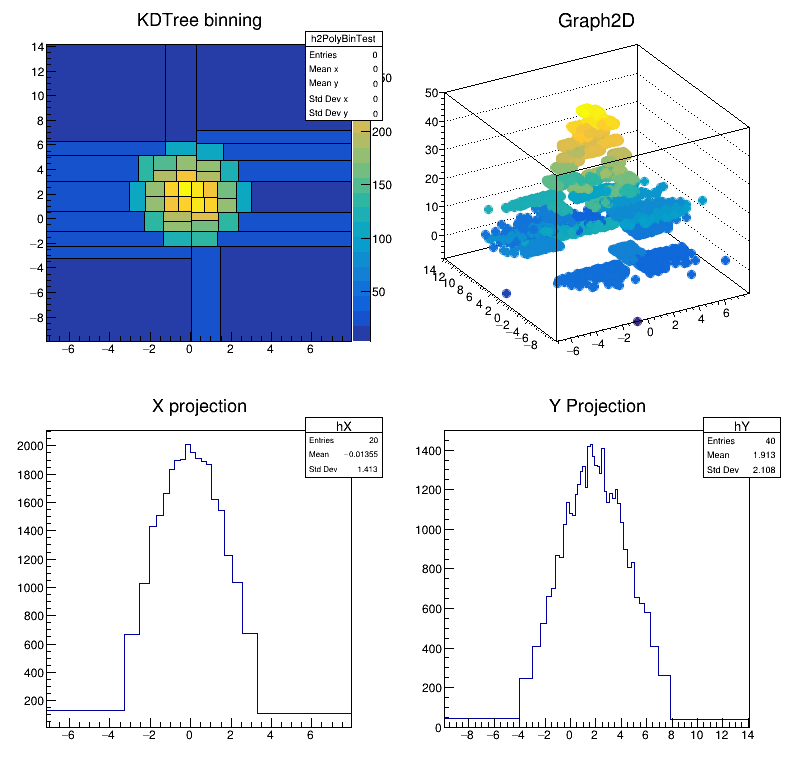

In [10]:
gROOT->GetListOfCanvases()->Draw()